# 1. Install Necessary Libraries

In [20]:
%%capture --no-stderr
%pip install -U langchain_community tiktoken langchain-openai langchain-cohere langchainhub chromadb langchain langgraph  tavily-python

# 2. Import necessary dependencies and set environment variables

In [21]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# RAG

Large Language Models (LLMs) have demonstrated impressive capabilities in generating human-like text, but they are limited by the data they were trained on. This is where Retrieval Augmented Generation (RAG) comes in. RAG enhances LLMs by allowing them to access and incorporate external knowledge sources, leading to more accurate, relevant, and grounded responses. This blog post will explore the four core areas of RAG: Indexing & Embedding, Retrieval, Augmentation through Prompting, and Generation.

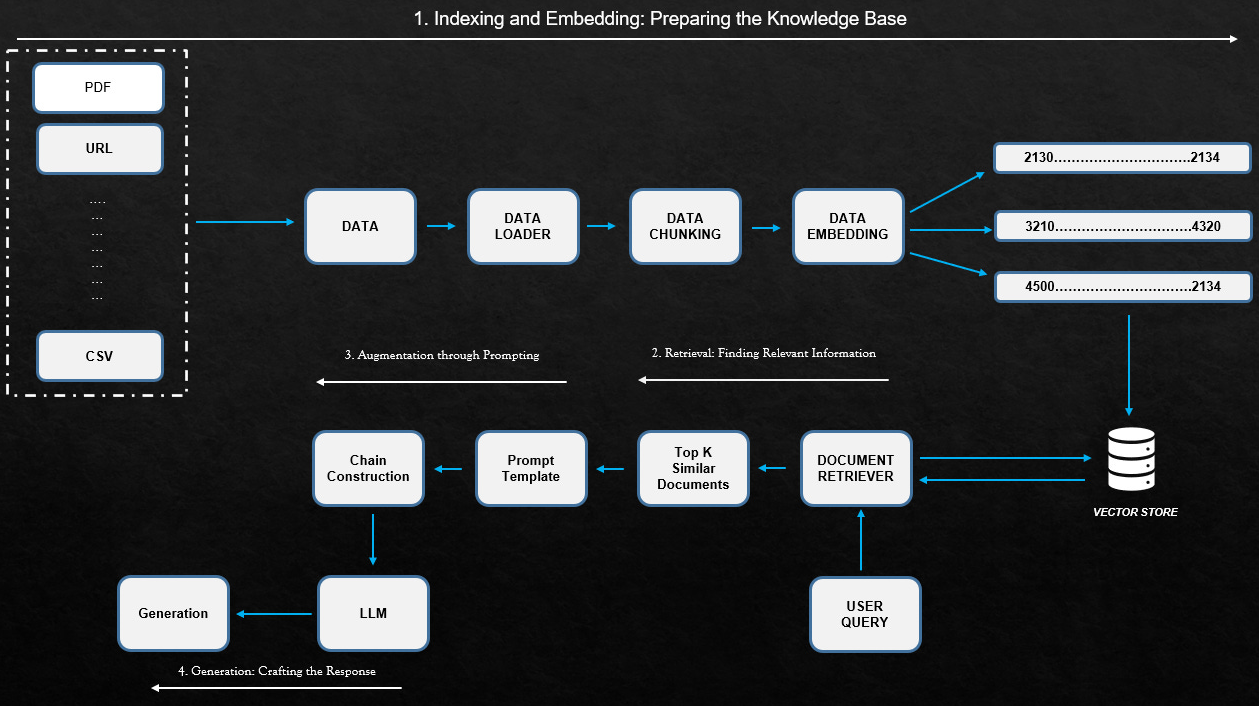

Detailed Blog :  https://aiproductplaybook.substack.com/p/2-rag-high-level-design

# 3. Adaptive RAG

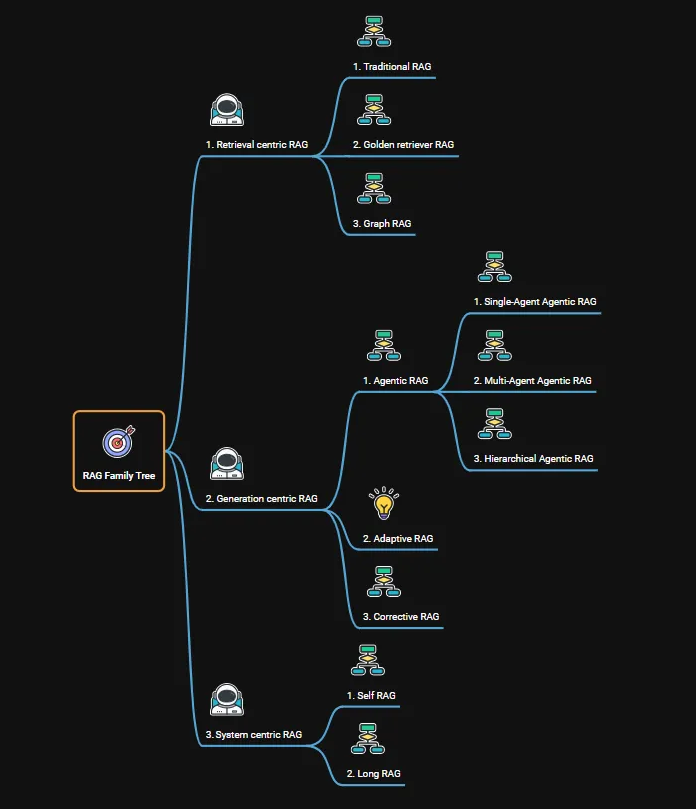

Detailed Blog : https://aiproductplaybook.substack.com/p/89-what-the-heck-are-adaptive-rag

### a. Adaptive RAG

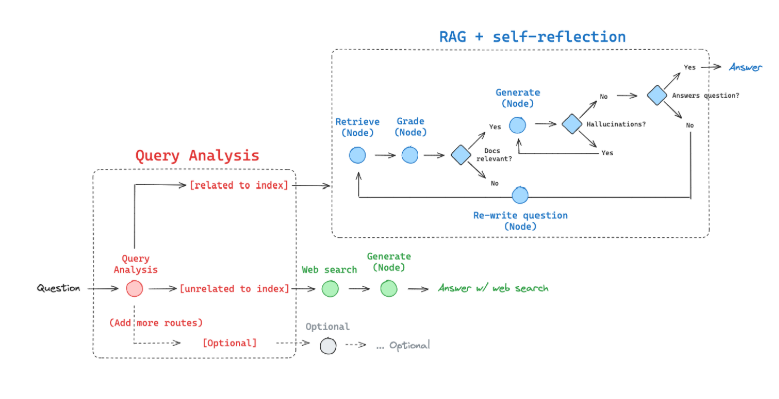

### b. Index the Knowledge Base

1. Import necessary dependencies

2. URLs : This list contains the URLs of the web pages you want to load.

3. Loading Web Pages

a. docs = [WebBaseLoader(url).load() for url in urls]: This uses a list comprehension to load the content of each URL using WebBaseLoader. The result is a list of lists, where each inner list contains the documents loaded from a single URL.

b. docs_list = [item for sublist in docs for item in sublist]: This flattens the list of lists into a single list of documents.

4. Text Splitting

a. text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(...): Creates a RecursiveCharacterTextSplitter object. This splitter recursively breaks down the text into chunks.

chunk_size=100: Specifies that each chunk should ideally be around 100 characters long.

chunk_overlap=50: Specifies that there should be a 50-character overlap between consecutive chunks. This helps preserve context across chunks.

from_tiktoken_encoder: This is an efficient way to count tokens, ensuring that chunks are split based on token count (which is more relevant for LLMs) rather than just character count. It requires the tiktoken library to be installed.

b. doc_splits = text_splitter.split_documents(docs_list): Splits the loaded documents into chunks using the configured text splitter.

5. Creating the Vector Database

a. vectorstore = Chroma.from_documents(...): Creates a Chroma vector database from the document chunks.

documents=doc_splits: Provides the list of document chunks.

collection_name="rag-chroma": Gives a name to the Chroma collection.

embedding=OpenAIEmbeddings(): Specifies that OpenAI's embeddings model should be used to create vector representations of the text chunks. This requires an OpenAI API key to be set as an environment variable (OPENAI_API_KEY).

b. retriever = vectorstore.as_retriever(): Creates a retriever object from the vector database. The retriever is used to fetch relevant chunks of text based on a query.

Summary

This code loads web pages, splits them into smaller, overlapping chunks using a tiktoken aware splitter, and then creates a Chroma vector database from these chunks.  It uses OpenAI embeddings to create vector representations of the text, which are stored in the vector database.  Finally, it creates a retriever, which can be used to efficiently retrieve relevant context from the documents based on a user's query. This setup is essential for building RAG applications, where relevant information is retrieved from a knowledge base to augment the capabilities of a large language model.

In [22]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

### c. Defining langchain Component for Query routing

1. Import necessary dependencies

2. RouteQuery Pydantic Model

a. This defines a Pydantic model RouteQuery to structure the LLM's output.

b. datasource: Literal["vectorstore", "web_search"]: This field is of type Literal. This means it can only have one of the two specified string values: "vectorstore" or "web_search". This forces the LLM to choose one of these options.

3. LLM and Structured Output

a. llm = ChatOpenAI(model="gpt-4o-mini", temperature=0): Creates a ChatOpenAI instance, using the "gpt-4o-mini" model and setting the temperature to 0 (for more deterministic output).

b. structured_llm_router = llm.with_structured_output(RouteQuery): This is the key part. The with_structured_output() method tells the LLM to format its output according to the RouteQuery Pydantic model. This means the LLM's response will be parsed and validated to ensure it has a datasource field with either "vectorstore" or "web_search" as its value.

4. Prompt template

a. system: This string defines the system message, setting the role of the LLM as an expert question router. It provides instructions on when to use the vectorstore versus web search.

b. route_prompt: This creates a ChatPromptTemplate with the system message and a human message placeholder for the user's question.

5. Creating the Router

This line creates the LangChain pipeline. The prompt is chained with the structured_llm_router (the LLM with structured output). When a question is passed to question_router.invoke(), the prompt is formatted, sent to the LLM, and the LLM's response is parsed according to the RouteQuery model.

6. Example invocation

These lines demonstrate how to use the question_router. They invoke the pipeline with two different questions:
The first question ("Who will the Bears draft...") is likely to be routed to "web_search" because it's not related to the vectorstore's topics.
The second question ("What are the types of agent memory?") is likely to be routed to "vectorstore" because it's related to agents.

summary

This code defines a question router that uses an LLM to decide whether a question should be answered using a vector database or a general web search. The RouteQuery Pydantic model ensures that the LLM's output is structured correctly, and the with_structured_output method makes it easy to parse the LLM's response.  This router can be a valuable component in a larger question-answering system.

In [23]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "Who will the Bears draft first in the NFL draft?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='web_search'
datasource='vectorstore'


### d. Binary grading of retrieved document

1. GradeDocuments Pydantic Model

a. Defines a Pydantic model GradeDocuments to structure the output of the relevance grading.

b. binary_score: str: This field will hold the "yes" or "no" score.

2. LLM and Structured Output

a. llm = ChatOpenAI(model="gpt-4o-mini", temperature=0): Creates a ChatOpenAI instance with a specific model and temperature.

b. structured_llm_grader = llm.with_structured_output(GradeDocuments): This is crucial. It tells the LLM to format its output according to the GradeDocuments Pydantic model. This means the LLM's response will be parsed and validated to ensure it has a binary_score field with either "yes" or "no" as its value.

3. Prompt Template

a. system: This string contains the instructions for the LLM. It tells the LLM to assess the relevance of a document to a question and provide a "yes" or "no" score. It emphasizes that the test doesn't need to be very strict and is primarily for filtering out bad retrievals.

b. grade_prompt: This creates a ChatPromptTemplate with the system message and a human message placeholder for the document and question.

4. Creating the Grader

The prompt is chained with the structured_llm_grader (the LLM with structured output). When the retrieval_grader.invoke() method is called, the prompt is formatted, sent to the LLM, and the LLM's response is parsed according to the GradeDocuments model.

5. Example Usage

a. question = "agent memory": Sets the question.

b. docs = retriever.invoke(question): Uses the retriever (assumed to be defined elsewhere) to retrieve relevant documents for the question.

c. doc_txt = docs[1].page_content: Extracts the content of the second retrieved document. Note that it's using docs[1], implying there are at least two retrieved documents, and it's grading the relevance of the second one.

d. print(retrieval_grader.invoke({"question": question, "document": doc_txt})): Invokes the retrieval_grader with the question and the document content. The output will be a GradeDocuments object.

summary

This code defines a component for grading the relevance of retrieved documents. It uses an LLM with structured output to get a "yes" or "no" score. The GradeDocuments Pydantic model ensures that the LLM's output is correctly formatted. This grader can be used to filter out irrelevant documents in a RAG pipeline, improving the quality of the final answer.  It's important to note that it's grading the relevance of one specific document (docs[1]) in this example.  In a typical RAG system, you would likely iterate through all retrieved documents and grade each one individually.

In [24]:
### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### e. RAG generation flow

This code uses a pre-built RAG prompt from the LangChain Hub to generate an answer to a question based on retrieved documents. It formats the documents, uses an LLM to generate the answer, and converts the output to a string. This is a typical RAG workflow, and using a Hub prompt simplifies the process.

In [25]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Agent memory in LLM-powered autonomous systems consists of short-term and long-term memory components. Short-term memory utilizes in-context learning for immediate tasks, while long-term memory allows agents to retain and recall information over extended periods, often using external databases for storage. This memory structure enables agents to learn from past experiences and improve their interactions and decision-making.


### f. Defining the Hallucination Grader

1. Import necessary dependencies

2. GradeHallucinations Pydantic Model

a. Defines a Pydantic model GradeHallucinations to structure the output of the hallucination grading.

b. binary_score: str: This field will hold the "yes" or "no" score.

3. LLM and Structured Output

a. llm = ChatOpenAI(model="gpt-4o-mini", temperature=0): Creates a ChatOpenAI instance.

b. structured_llm_grader = llm.with_structured_output(GradeHallucinations): Tells the LLM to format its output according to the GradeHallucinations Pydantic model.

4. Prompt template

system: Instructions for the LLM, defining it as a hallucination grader.

hallucination_prompt: A ChatPromptTemplate with the system message and a human message placeholder for the facts and the generated answer.

5. Creating the Hallucination Grader

Creates a LangChain pipeline: prompt + LLM with structured output

6. Example Usage

invokes the hallucination_grader with the retrieved documents (docs) and the generated answer (generation). It's assumed that docs and generation are defined elsewhere (likely from a previous RAG step).

summary

This code defines a component to check for hallucinations in LLM-generated answers. It uses an LLM with structured output to get a "yes" or "no" score indicating whether the answer is supported by the provided facts. This hallucination grader can be a crucial part of a RAG pipeline to ensure the reliability and factual accuracy of the generated answers.

In [26]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

### g. Define the Answer Grader

This code defines a component to check if an LLM-generated answer addresses the user's question. It uses an LLM with structured output to get a "yes" or "no" score. The GradeAnswer Pydantic model ensures that the LLM's output is correctly formatted. This answer grader can be used in a QA pipeline to evaluate the quality and relevance of the generated answers.

In [27]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

### h. Define the Question Re-writer

This code defines a component to rewrite questions for better vectorstore retrieval. It uses an LLM to rephrase the input question, focusing on preserving the semantic meaning and optimizing it for search. The StrOutputParser ensures the output is a string, making it easy to use in subsequent steps of a retrieval pipeline.  This rewritten question can then be used to query the vector database, potentially leading to more relevant results.

In [28]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the key concepts and techniques related to agent memory in artificial intelligence?'

### i. Defining the Web search tool

This code creates a ready-to-use LangChain tool called web_search_tool that uses the Tavily API to perform web searches. When this tool is invoked, it will execute a search using the provided query and return the top 3 results.  This tool can then be used by LangChain agents or chains to incorporate web search functionality into their workflows.  For this to work, you'll need to make sure you have your Tavily API key configured (usually as the environment variable TAVILY_API_KEY).

In [29]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

### j. Define the Graph State

The GraphState TypedDict defines a structured way to represent the state of a graph in a LangChain application. It holds the user's question, the LLM's generated output, and a list of relevant documents.  Using a TypedDict provides type safety and makes the code more readable by clearly defining the structure of the state. It allows for static analysis and helps prevent errors related to incorrect data types.

In [32]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

### k. Define the Graph flow

1. retrieve(state):

Purpose: Retrieves relevant documents based on the question.

Logic:

Prints "---RETRIEVE---" for logging.

Extracts the question from the state dictionary.

Uses a retriever object (assumed to be defined elsewhere) to fetch relevant documents.

Returns a new dictionary containing the retrieved documents and the original question.

2. generate(state):

Purpose: Generates an answer using the retrieved documents and the question.

Logic:

Prints "---GENERATE---".

Extracts the question and documents from the state.

Uses a rag_chain (assumed to be a LangChain chain for RAG) to generate the answer.

Returns a new dictionary containing the documents, question, and the generated generation.

3. grade_documents(state):

Purpose: Grades the relevance of the retrieved documents to the question.

Logic:

Prints "---CHECK DOCUMENT RELEVANCE TO QUESTION---".

Extracts question and documents from the state.

Iterates through each document:

Uses a retrieval_grader (assumed to be a LangChain component for grading) to score the document's relevance.

If the binary_score from the retrieval_grader is "yes", the document is added to filtered_docs.

Returns a new dictionary with the documents key updated to contain only the filtered_docs and the original question.

4. transform_query(state):

Purpose: Rewrites the question to be more effective for retrieval.

Logic:

Prints "---TRANSFORM QUERY---".

Extracts question and documents from the state.

Uses a question_rewriter (assumed to be a LangChain component for rewriting questions) to generate a better_question.

Returns a new dictionary with the question key updated to the better_question, and the original documents.

5. web_search(state):

Purpose: Performs a web search based on the question.

Logic:

Prints "---WEB SEARCH---".

Extracts the question from the state.

Uses a web_search_tool (assumed to be a LangChain tool for web searches) to perform the search.

Formats the web search results into a LangChain Document object.

Returns a new dictionary with the documents key updated to contain the web search results, and the original question.

6. route_question(state):

Purpose: Routes the question to either web search or RAG based on the question
type.

Logic:

Prints "---ROUTE QUESTION---".

Extracts the question from the state.

Uses a question_router (assumed to be a LangChain component for routing questions) to determine the appropriate data source.

Returns either "web_search" or "vectorstore" to indicate the next step in the graph.

7. decide_to_generate(state):

Purpose: Decides whether to generate an answer or transform the query.

Logic:

Prints "---ASSESS GRADED DOCUMENTS---".

Extracts the question and filtered_documents from the state.

If filtered_documents is empty (no relevant documents were found), it returns "transform_query".

Otherwise, it returns "generate".

8. grade_generation_v_documents_and_question(state):

Purpose: Checks if the generated answer is grounded in the documents and answers the question.

Logic:

Prints "---CHECK HALLUCINATIONS---".

Extracts question, documents, and generation from the state.

Uses a hallucination_grader to check if the generation is grounded in the documents.

If the generation is grounded, it uses an answer_grader to check if it answers the question.

Returns "useful", "not useful", or "not supported" based on the grading results.

summary

These functions define the individual steps and decision points in a RAG pipeline. They handle retrieval, generation, document and generation grading, query transformation, and routing.  These functions would be connected together in a LangChain graph to create the full RAG workflow.  The use of print statements provides logging and helps in debugging the flow of the graph.

In [33]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### l. Define and visualize the design

In [34]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

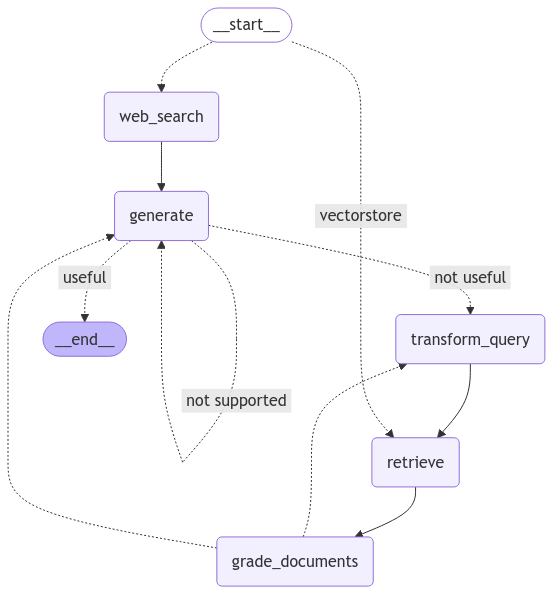

In [35]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### g. Invoke the RAG

In [36]:
from pprint import pprint

# Run
inputs = {
    "question": "Who won the Golden ball in Men's Football world cup 2022?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Lionel Messi won the Golden Ball at the FIFA World Cup 2022, awarded to the '
 "tournament's best player. This marked Messi's second time receiving the "
 'Golden Ball, making him the first player to achieve this feat.')


In [37]:
# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The types of agent memory are short-term memory and long-term memory. '
 'Short-term memory involves in-context learning, while long-term memory '
 'allows the agent to retain and recall information over extended periods, '
 'often using an external vector store.')


In [39]:
from pprint import pprint

# Run
inputs = {
    "question": "Who won the men's singles wimbledon open 2024?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
("Carlos Alcaraz won the men's singles title at the 2024 Wimbledon "
 'Championships, defeating Novak Djokovic in the final. The match ended with a '
 "score of 6–2, 6–2, 7–6(7–4). This victory marked Alcaraz's second Wimbledon "
 'title.')


In [40]:
# Run
inputs = {"question": "What are the different types of Task Decomposition?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The different types of task decomposition include decomposition-first and '
 'interleaved decomposition. Decomposition-first focuses on breaking down '
 'tasks into distinct elements before execution, while interleaved '
 'decomposition involves analyzing and executing tasks concurrently. Both '
 'methods aim to enhance productivity and streamline workflows in various '
 'contexts, such as project management and product development.')


In [41]:
# Run
inputs = {"question": "What is Self Reflection?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
("Self-reflection is the process of evaluating and contemplating one's own "
 'thoughts, emotions, and behaviors to gain a deeper understanding of oneself. '
 'It involves setting aside time to think critically about personal values, '
 'motivations, and actions. This practice is essential for personal growth and '
 'self-awareness.')


In [42]:
# Run
inputs = {"question": "What does Lilian Weng say about different types of Task Decomposition??"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Lilian Weng discusses task decomposition as a technique to break down '
 'complex tasks into smaller, manageable steps. She mentions that it can be '
 'achieved through various methods, including simple prompting techniques and '
 'task-specific approaches. This process helps facilitate easier execution and '
 'understanding of tasks.')


In [43]:
# Run
inputs = {"question": "What are the types of CoT prompts?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
'---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---'
"Node 'generate':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
"Node 'generate':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
--

In [44]:
# Run
inputs = {"question": "What is Tree of Thoughts?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Tree of Thoughts (ToT) is a framework designed to enhance the reasoning '
 'capabilities of large language models (LLMs) by allowing them to explore '
 'multiple decision paths before making a choice. It employs a tree-like '
 'structure for problem-solving, enabling models to evaluate various outcomes '
 'and break complex tasks into smaller decisions. This approach aims to make '
 "LLMs' reasoning more human-like and effective in strategic thinking and "
 'decision-making.')


In [46]:
# Run
inputs = {"question": "What does Lilian Weng say about White-box vs Black-box attacks?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Lilian W

In [47]:
# Run
inputs = {"question": "What is Jailbreak prompting ?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Jailbreak prompting refers to adversarial techniques used to trigger large '
 'language models (LLMs) to produce harmful content that should be restricted. '
 'These prompts are often based on heuristic and manual exploration, '
 "functioning as black-box attacks against the model's built-in safety "
 "mechanisms. The goal is to exploit vulnerabilities in the model's design to "
 'bypass safety measures.')
